# Import Important Library

In [8]:
import pandas as pd #for reaed data
import re #for text cleansing

from nltk.corpus import stopwords #for clean stopwords

#visualization
import matplotlib.pyplot as plt
import seaborn as sns 

#save model
import pickle

## Read Data

In [9]:
dfText = pd.read_csv('dataset/train_preprocess_-_BALANCE.tsv', sep='\t', names=['text', 'label'])
dfText.head()

,text,label
0,saya tadinya penasaran dengan tempat ini karen...,negative
1,"kang , jalan di muararajeun baru , baru sebula...",negative
2,melihat itu kader demokrat ribut dengan pak hn...,negative
3,"tak usah nonton film itu , bahasa jawa semua ....",negative
4,"ini si monyet bawah gua , nama nya saja anonim...",negative


In [10]:
dfAlay = pd.read_csv('dataset/new_kamusalay.csv', encoding='latin-1', names=['original', 'replacement'])
dfAlay

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [11]:
dfStopWord = pd.read_csv('dataset/stopwordbahasa.csv', names=['stopword'])
dfStopWord

,stopword
0,gue
1,gua
2,ya
3,yg
4,ga
...,...
782,wong
783,yaitu
784,yakin
785,yakni


# Cleansing Text

In [12]:
# remove kata alay
def normalize_alay(text):
    alay_dict_map = dict(zip(dfAlay['original'], dfAlay['replacement']))
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

# remove punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]',' ',text)

# remove stopword
def remove_stopword(text):
    stopword_list = set(stopwords.words('indonesian'))
    return ' '.join([word for word in text.split(' ') if word not in stopword_list])

In [13]:
def preprocess(text):
    text = normalize_alay(text)
    text = remove_punctuation(text)
    text = remove_stopword(text)
    return text

In [14]:
dfText['text'] = dfText['text'].apply(preprocess)
dfText['text'] = dfText['text'].str.lower()
dfText

,text,label
0,penasaran nya foto foto kunjungan artis pas pe...,negative
1,kang jalan muararajeun sebulanan dibenarka...,negative
2,kader demokrat ribut hnw partai keadilan sejah...,negative
3,menonton film bahasa jawa mengerti teks ...,negative
4,sih monyet gue nama nya anonim pengecut paka...,negative
...,...,...
10195,mereka mempertahankan spesifikasi dasar model ...,neutral
10196,mereka mempertahankan kejuaraan memenangkan k...,neutral
10197,mereka mempertahankan gelar juara 2016 mengal...,neutral
10198,mereka mempertahankan kemerdekaan administrati...,neutral


In [15]:
dictLabel = {'neutral' : 0, 'positive' : 1, 'negative' : 2}
dfText['label'] = dfText['label'].map(dictLabel)
dfText['label']

0        2
1        2
2        2
3        2
4        2
        ..
10195    0
10196    0
10197    0
10198    0
10199    0
Name: label, Length: 10200, dtype: int64

# EDA

## Check Info Data

In [16]:
len(dfText)

10200

In [17]:
dfText.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10200 non-null  object
 1   label   10200 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 159.5+ KB


In [18]:
dfText.isnull().sum()

text     0
label    0
dtype: int64

# Tf-idf Transformer

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras_preprocessing.sequence import pad_sequences

In [20]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(dfText['text'])
X_train_counts.shape

with open('models/count_vect.pkl', 'wb') as f:
    pickle.dump(count_vect, f)

In [21]:
tf_tranformer =TfidfTransformer(smooth_idf=True,use_idf=True).fit(X_train_counts)
X_train_tf = tf_tranformer.transform(X_train_counts).toarray()
X_train_tf.shape

with open('models/tf_tranformer.pkl', 'wb') as f:
    pickle.dump(tf_tranformer, f)

# Tokenization and Change Label to Categorical

In [22]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [23]:
arrayLabel = dfText['label'].to_numpy()

In [24]:
import tensorflow as tf

labels = tf.keras.utils.to_categorical(arrayLabel, 3, dtype="float32")

In [25]:
len(labels)

10200

In [26]:
max_words = 10200
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(dfText['text'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(dfText['text'])
text = pad_sequences(sequences, maxlen=max_len)
print(text.shape)

with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

(10200, 200)


In [27]:
print(type(text))

<class 'numpy.ndarray'>


# Training

In [28]:
from keras.models import Sequential, load_model
from keras import layers
from keras.optimizers import RMSprop,Adam   
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

## Split Data

In [29]:
# split tfidftransformers data
from sklearn.model_selection import train_test_split

X_train_transf, X_test_transf, y_train_transf, y_test_transf = train_test_split(X_train_tf,labels, random_state=0)
print(len(X_train_transf),len(X_test_transf),len(y_train_transf),len(y_test_transf))

7650 2550 7650 2550


In [30]:
# split tokenization data
from sklearn.model_selection import train_test_split

X_train_token, X_test_token, y_train_token, y_test_token = train_test_split(text,labels, random_state=0)
print(len(X_train_token),len(X_test_token),len(y_train_token),len(y_test_token))

7650 2550 7650 2550


## LSTM

In [24]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train_token, y_train_token, epochs=70,validation_data=(X_test_token, y_test_token),callbacks=[checkpoint1])
model1.save('models/LSTMmodel.h5')

Epoch 1/70
240/240 [==============================] - ETA: 0s - loss: 0.8267 - accuracy: 0.6230
Epoch 1: val_accuracy improved from -inf to 0.75686, saving model to best_model1.hdf5
240/240 [==============================] - 19s 68ms/step - loss: 0.8267 - accuracy: 0.6230 - val_loss: 0.6256 - val_accuracy: 0.7569
Epoch 2/70
240/240 [==============================] - ETA: 0s - loss: 0.4998 - accuracy: 0.8182
Epoch 2: val_accuracy improved from 0.75686 to 0.81412, saving model to best_model1.hdf5
240/240 [==============================] - 13s 56ms/step - loss: 0.4998 - accuracy: 0.8182 - val_loss: 0.4772 - val_accuracy: 0.8141
Epoch 3/70
240/240 [==============================] - ETA: 0s - loss: 0.3852 - accuracy: 0.8647
Epoch 3: val_accuracy improved from 0.81412 to 0.84118, saving model to best_model1.hdf5
240/240 [==============================] - 14s 57ms/step - loss: 0.3852 - accuracy: 0.8647 - val_loss: 0.4181 - val_accuracy: 0.8412
Epoch 4/70
240/240 [=============================

## ANN

In [25]:
from sklearn.neural_network import MLPClassifier
import pickle

clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32), activation="relu",random_state=1, solver='adam', alpha=1e-5, early_stopping=True, max_iter=1000, verbose=True)
clf.fit(X_train_transf,y_train_transf)

pkl_filename = "models/ANNmodel.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file) 

Iteration 1, loss = 1.94635042
Validation score: 0.454902
Iteration 2, loss = 0.96195108
Validation score: 0.840523
Iteration 3, loss = 0.31333463
Validation score: 0.852288
Iteration 4, loss = 0.13787652
Validation score: 0.847059
Iteration 5, loss = 0.08077823
Validation score: 0.837908
Iteration 6, loss = 0.05662197
Validation score: 0.832680
Iteration 7, loss = 0.04618218
Validation score: 0.847059
Iteration 8, loss = 0.03764150
Validation score: 0.824837
Iteration 9, loss = 0.03639285
Validation score: 0.836601
Iteration 10, loss = 0.03694461
Validation score: 0.836601
Iteration 11, loss = 0.03570344
Validation score: 0.832680
Iteration 12, loss = 0.03162549
Validation score: 0.833987
Iteration 13, loss = 0.02976242
Validation score: 0.831373
Iteration 14, loss = 0.02850119
Validation score: 0.831373
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [54]:
y_pred=clf.predict(X_test_transf)
y_pred

neutral


# Validation

In [59]:
import numpy as np
import keras
from sklearn.metrics import confusion_matrix

## LSTM

In [70]:
best_model = keras.models.load_model("models/LSTMmodel.h5")

In [71]:
test_loss, test_acc = best_model.evaluate(X_test_token, y_test_token, verbose=2)
print('Model accuracy: ',test_acc)

80/80 - 2s - loss: 0.3560 - accuracy: 0.8843 - 2s/epoch - 29ms/step
Model accuracy:  0.884313702583313


In [72]:
predictions = best_model.predict(X_test_token)

80/80 [==============================] - 3s 24ms/step


In [73]:
matrix = confusion_matrix(y_test_token.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

C:\Users\ansha\AppData\Local\Temp/ipykernel_21808/3444368053.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


<AxesSubplot:>

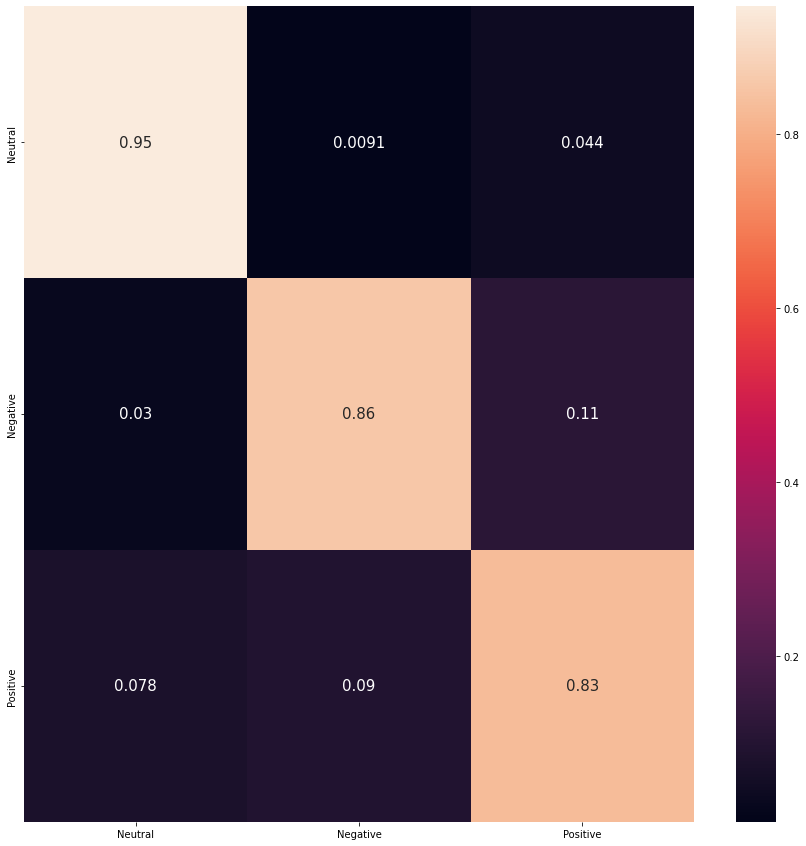

In [74]:
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [104]:
label = ['neutral', 'positive', 'negative']

In [107]:
sequence = tokenizer.texts_to_sequences(['makanan disini enak banget dan harga nya murah murah'])
test = pad_sequences(sequence, maxlen=max_len)
label[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 60ms/step


'positive'

## ANN

In [51]:
import numpy as np
np.mean(y_pred == y_test_transf)

0.914640522875817

In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_test_transf, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       881
           1       0.86      0.86      0.86       839
           2       0.84      0.80      0.82       830

   micro avg       0.88      0.86      0.87      2550
   macro avg       0.88      0.86      0.87      2550
weighted avg       0.88      0.86      0.87      2550
 samples avg       0.85      0.86      0.86      2550



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
